© British Crown Copyright 2017-2025, Met Office. Please see LICENSE.md for license details.

In [1]:
import xarray as xr
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Determine the device to use
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [3]:
# Loading and combining datasets
path = "./data"
nc_files = glob.glob(os.path.join(path, "*.nc"))

datasets = [xr.open_dataset(f, engine='netcdf4') for f in nc_files]

combined_ds = xr.concat(datasets, dim='time')

In [4]:
# Defining the config and hyperparameters
config = {
    'time_step': 1,
    'batch_size': 16,
    'num_epochs':50,
    'learning_rate': 1e-4,
    'test_size': 0.2,
}

In [5]:
# Standardize the data
mean_tas = combined_ds.tas.mean(dim='time', skipna=True)
std_tas = combined_ds.tas.std(dim='time', skipna=True)

standardized_tas = (combined_ds.tas - mean_tas) / std_tas

time_index = 0
standardized_tas_slice = standardized_tas.isel(time=time_index)

In [6]:
# # Fill nan values with 0s
filled_standardized_tas = standardized_tas.fillna(0)
filled_standardized_tas = combined_ds.tas.fillna(0)

data = filled_standardized_tas.values.astype(np.float32)

data_shape = data.shape

if len(data_shape) < 2:
    raise ValueError("Data must have at least two dimensions for x and y.")

x_dim = data_shape[-2]
y_dim = data_shape[-1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_data = np.pad(data, ((0, 0),) * (len(data_shape) - 2) + ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_data = np.expand_dims(padded_data, axis=1)
expanded_data.shape

(600, 1, 56, 56)

In [7]:
# Create a dataset to serve the data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, time_step=1):
        self.time_step = time_step
        self.data = data

    def __len__(self):
        return len(self.data) - self.time_step * 2

    def __getitem__(self, idx):
        return np.concatenate((self.data[idx], self.data[idx+self.time_step]), axis=0), self.data[idx+self.time_step*2]

dataset = TimeSeriesDataset(expanded_data)

In [8]:
# Split into test and train datasets
test_size = int(len(dataset) * config['test_size'])
train_size = len(dataset) - test_size 

indices = np.arange(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

In [9]:
# Define model
class CNNTimeSeriesForecast(nn.Module):
    def __init__(self, input_size, mlp_expand_size=4):
        super(CNNTimeSeriesForecast, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size[0], 16, kernel_size=(3,3), stride=2, padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.flattened_size = self._get_flattened_size(input_size)

        self.mlp = nn.Sequential(
            nn.Linear(self.flattened_size, self.flattened_size * mlp_expand_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size * mlp_expand_size, self.flattened_size),
        )

        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.activation = nn.ReLU()

    def _get_flattened_size(self, input_size):
        dummy_input = torch.zeros(2, *input_size)
        with torch.no_grad():
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.view(x.size(0), -1).size(1)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        x_batch, x_channel, x_height, x_width = x3.shape
        x = x3.view(x3.size(0), -1)
        x = self.mlp(x)
        x = x.reshape(x_batch, x_channel, x_height, x_width)

        x = x + x3
        x = self.activation(self.conv_transpose3(x))
        x = x + x2  
        x = self.activation(self.conv_transpose2(x))
        x = x + x1  
        x = self.conv_transpose1(x)

        return x

dummy_input= next(iter(test_loader))[0].to(device)
model = CNNTimeSeriesForecast(input_size=dummy_input[0].shape).to(device)

model(dummy_input).shape

torch.Size([16, 1, 56, 56])

In [10]:
# Create a mask over the non-null values
non_null_mask = combined_ds.tas.notnull()
collapsed_mask = np.all(non_null_mask.values, axis=0)

mask_shape = collapsed_mask.shape
x_dim = mask_shape[0]
y_dim = mask_shape[1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_mask = np.expand_dims(padded_mask, axis=0)

batch_size = config['batch_size']
batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

mask_tensor = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
mask_tensor.shape

torch.Size([16, 1, 56, 56])

In [11]:
# Training set up
criterion = nn.MSELoss(reduction='none')  
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [12]:
# Training loop
for epoch in range(config['num_epochs']):
    model.train()  
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)

        # Apply the mask to the outputs and labels
        masked_loss = criterion(outputs, labels) * mask_tensor
        loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    train_loss /= len(train_loader)

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            # Apply the mask to the outputs and labels
            masked_loss = criterion(outputs, labels) * mask_tensor
            loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch}/{config['num_epochs']-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [0/49], Train Loss: 76.3284, Test Loss: 45.8344


Epoch [1/49], Train Loss: 22.9480, Test Loss: 10.6240


Epoch [2/49], Train Loss: 7.7535, Test Loss: 6.8599


Epoch [3/49], Train Loss: 5.8297, Test Loss: 5.2156


Epoch [4/49], Train Loss: 5.0174, Test Loss: 4.5413


Epoch [5/49], Train Loss: 3.8794, Test Loss: 4.4991


Epoch [6/49], Train Loss: 4.3479, Test Loss: 4.1900


Epoch [7/49], Train Loss: 3.8180, Test Loss: 4.0471


Epoch [8/49], Train Loss: 3.6184, Test Loss: 3.9262


Epoch [9/49], Train Loss: 3.2022, Test Loss: 4.0237


Epoch [10/49], Train Loss: 3.4148, Test Loss: 4.1006


Epoch [11/49], Train Loss: 3.1999, Test Loss: 4.3690


Epoch [12/49], Train Loss: 3.0548, Test Loss: 3.7488


Epoch [13/49], Train Loss: 3.0628, Test Loss: 3.7158


Epoch [14/49], Train Loss: 2.7561, Test Loss: 3.6064


Epoch [15/49], Train Loss: 2.9722, Test Loss: 3.7734


Epoch [16/49], Train Loss: 2.9959, Test Loss: 3.5839


Epoch [17/49], Train Loss: 2.8286, Test Loss: 3.4719


Epoch [18/49], Train Loss: 2.6111, Test Loss: 3.4483


Epoch [19/49], Train Loss: 2.5619, Test Loss: 3.3811


Epoch [20/49], Train Loss: 2.4988, Test Loss: 3.3423


Epoch [21/49], Train Loss: 2.3922, Test Loss: 3.3875


Epoch [22/49], Train Loss: 2.4236, Test Loss: 3.3698


Epoch [23/49], Train Loss: 2.5281, Test Loss: 3.2731


Epoch [24/49], Train Loss: 2.5994, Test Loss: 3.3690


Epoch [25/49], Train Loss: 2.1886, Test Loss: 2.9450


Epoch [26/49], Train Loss: 2.3070, Test Loss: 3.1874


Epoch [27/49], Train Loss: 2.1076, Test Loss: 2.9890


Epoch [28/49], Train Loss: 2.1109, Test Loss: 2.8648


Epoch [29/49], Train Loss: 2.1442, Test Loss: 2.8455


Epoch [30/49], Train Loss: 2.1805, Test Loss: 3.0558


Epoch [31/49], Train Loss: 2.1211, Test Loss: 3.0142


Epoch [32/49], Train Loss: 2.0597, Test Loss: 2.7502


Epoch [33/49], Train Loss: 2.2694, Test Loss: 3.1156


Epoch [34/49], Train Loss: 1.9799, Test Loss: 2.7510


Epoch [35/49], Train Loss: 1.9850, Test Loss: 3.0331


Epoch [36/49], Train Loss: 2.0615, Test Loss: 3.1867


Epoch [37/49], Train Loss: 2.0611, Test Loss: 2.7646


Epoch [38/49], Train Loss: 1.9385, Test Loss: 2.8574


Epoch [39/49], Train Loss: 2.1137, Test Loss: 2.6691


Epoch [40/49], Train Loss: 1.9422, Test Loss: 2.7068


Epoch [41/49], Train Loss: 2.1735, Test Loss: 3.6821


Epoch [42/49], Train Loss: 2.2497, Test Loss: 3.8817


Epoch [43/49], Train Loss: 2.0560, Test Loss: 2.6349


Epoch [44/49], Train Loss: 1.9093, Test Loss: 3.0432


Epoch [45/49], Train Loss: 2.1484, Test Loss: 2.7357


Epoch [46/49], Train Loss: 1.9997, Test Loss: 2.9078


Epoch [47/49], Train Loss: 1.8981, Test Loss: 2.7229


Epoch [48/49], Train Loss: 1.7877, Test Loss: 2.4796


Epoch [49/49], Train Loss: 2.0035, Test Loss: 2.7609


In [13]:
# Run the model on one example
features, labels = next(iter(test_loader))
features, labels = features.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(features)

features = features.cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.cpu().numpy()
mask = mask_tensor.cpu().numpy()

masked_output = outputs * mask

difference = labels - masked_output

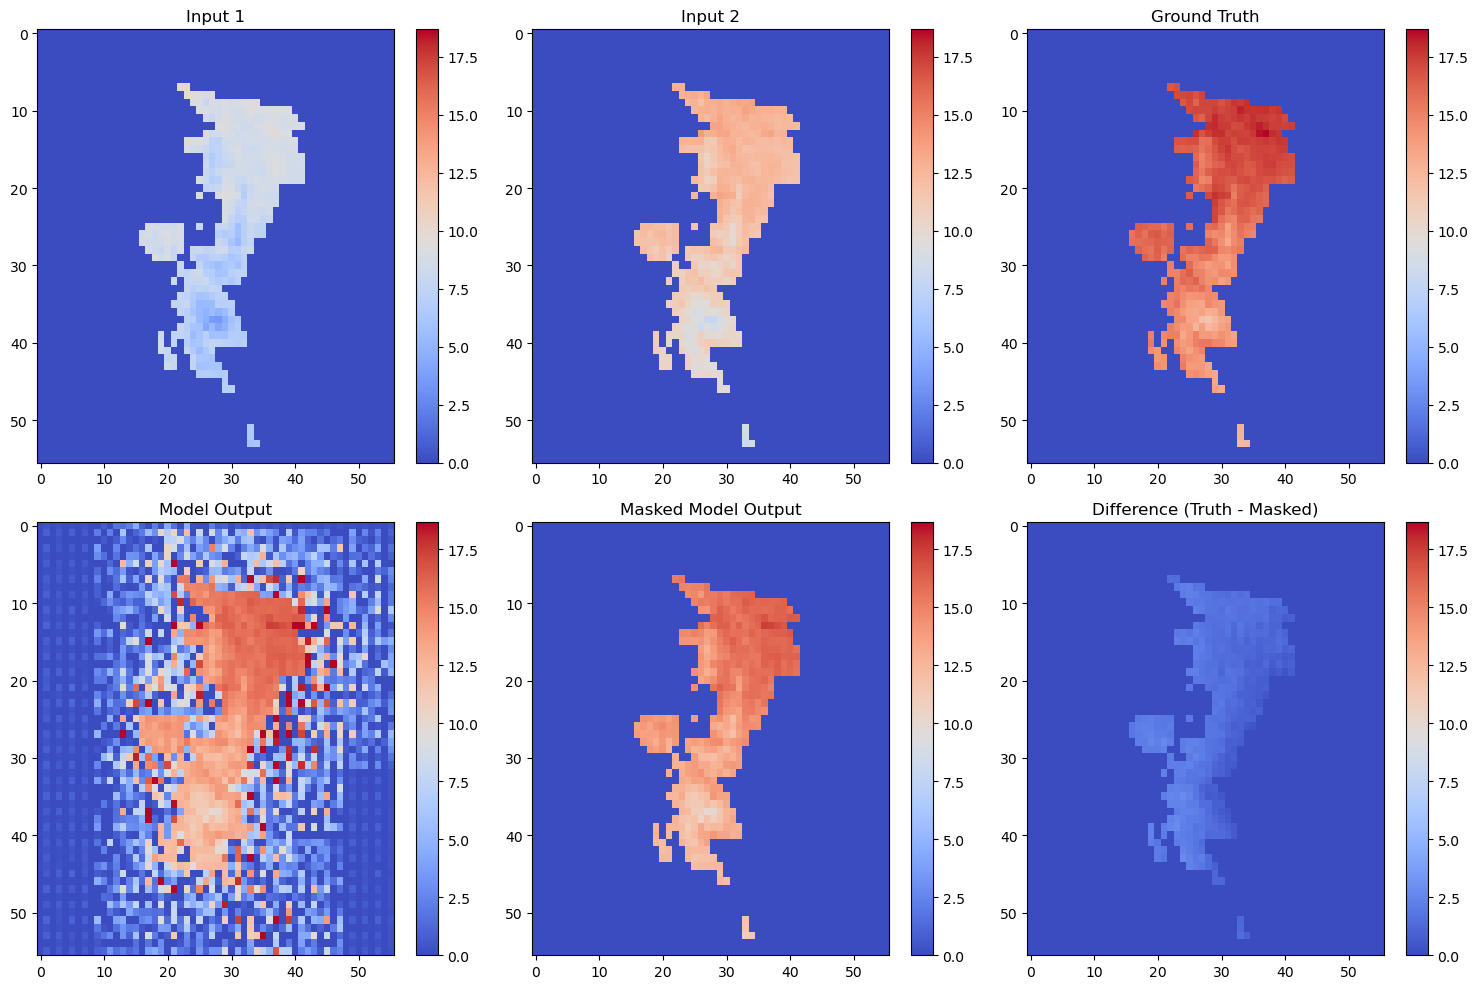

In [14]:
# Visualise the input and output data
sample_index = 4
vmin = min(features[sample_index].min(), labels[sample_index].min(), masked_output[sample_index].min(), difference[sample_index].min())
vmax = max(features[sample_index].max(), labels[sample_index].max(), masked_output[sample_index].max(), difference[sample_index].max())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(features[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 1')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(features[sample_index, 1], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 2')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(labels[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(outputs[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Model Output')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(masked_output[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Masked Model Output')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(difference[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Difference (Truth - Masked)')
plt.colorbar()

plt.tight_layout()
plt.show()